In [1]:
from __future__ import division
import tensorflow as tf
import numpy as np
import pywt
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import dataload
import transform

In [2]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,             # Channel to be used
    'dur_epoch': 30,          # Time of window page [s]
    'n2_val': 3,              # N2 state coding value
    'context': 1.28,          # Length of context for timestep, in [s]
    'factor_border': 2,
    # spectrogram will be computed in a segment of length (factor_border+1)*context to avoid border effects
    'mark_smooth': 1          # Number of samples to average at the center to get the segment central mark.
    # 'dur_min_ss': 0.3,      # Min SS duration [s]
    # 'dur_max_ss': 3.0       # Max SS duration [s]
}

In [3]:
# Read first register
signal_list = []
marks_list = []
states_list = []
for i in range(1):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = dataload.read_eeg(path_edf_file, params['channel'])
    signal_list.append(signal)
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks = dataload.read_marks(path_marks_file, params['channel'])
    marks_list.append(marks)
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = dataload.read_states(path_states_file)
    states_list.append(states)    
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(signal_list), ' EEG signals have been read.')
print(len(marks_list), ' sleep spindle marks files have been read.')
print(len(states_list), ' state annotations files have been read.')
print('Sampling Frequency: ', fs, 'Hz')

1  EEG signals have been read.
1  sleep spindle marks files have been read.
1  state annotations files have been read.
Sampling Frequency:  200 Hz


Chosen epoch: 31


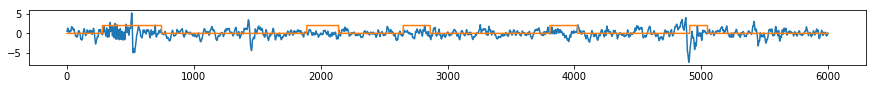

length of mini_signal is 768
central sample: 0.08919284642345487
central sample: 0.08919284642345487


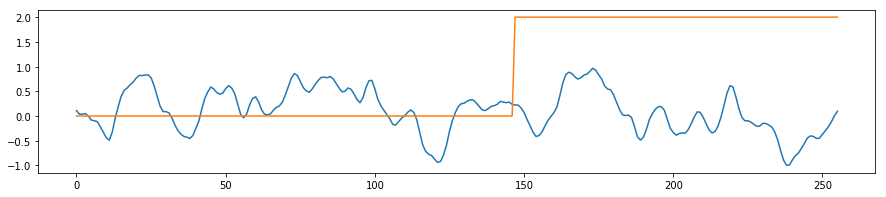

In [4]:
# first n2 epoch
signal = signal_list[0]
states = states_list[0]
marks = marks_list[0]
marks = transform.inter2seq(marks, 0, len(signal) - 1)

useful = np.where(states == params["n2_val"])
epoch = useful[0][3]
print("Chosen epoch: "+str(epoch))

# get segment
sample_start = epoch * params['dur_epoch'] * params['fs']
sample_end = (epoch + 1) * params['dur_epoch'] * params['fs']
segment_signal = signal[sample_start:sample_end]
segment_marks = marks[sample_start:sample_end]

# Normalize signal
segment_signal = (segment_signal - np.mean(segment_signal)) / np.std(segment_signal)

# Show segment
plt.figure(figsize=(15, 1))
plt.plot(segment_signal)
plt.plot(2*segment_marks)
plt.show()

# Mini segment
central_sample = 2000
sample_start = central_sample - int( (params['factor_border']+1)*params['context']*params['fs']/2 )
sample_end = central_sample + int( (params['factor_border']+1)*params['context']*params['fs']/2 )
mini_signal = segment_signal[sample_start:sample_end]
mini_marks = segment_marks[sample_start:sample_end]
print("length of mini_signal is", len(mini_signal))
print('central sample:', segment_signal[central_sample])
print('central sample:', mini_signal[int(len(mini_signal)/2)])
# Plot mini segment
plt.figure(figsize=(15, 3))
plt.plot(mini_signal[128:384])
plt.plot(2*mini_marks[128:384])
plt.show()

In [5]:
# Get a simple minibatch
batch_size = 64
central_samples = np.random.choice(range(500, 5500), batch_size)
segment_size = int((params['factor_border']+1)*params['context']*params['fs'])
print("Segment size", segment_size)
minibatch = np.zeros((batch_size,segment_size) )
for i in range(len(central_samples)):
    central_sample = central_samples[i]
    sample_start = central_sample - int( (params['factor_border']+1)*params['context']*params['fs']/2 )
    sample_end = central_sample + int( (params['factor_border']+1)*params['context']*params['fs']/2 )
    minibatch[i,:] = segment_signal[sample_start:sample_end]
print("Minibatch", minibatch.shape)

Segment size 768
Minibatch (64, 768)


In [6]:
# Compute CWT the usual way
def get_cwt_minibatch(signal_minibatch):
    fs = 200
    fc = 1
    fb_array = np.array([0.5, 1, 1.5, 2])
    n_scales = 32
    upper_freq = 40
    lower_freq = 2
    # Generate initial and last scale
    s_0 = fs / upper_freq
    s_n = fs / lower_freq
    # Generate the array of scales
    base = np.power(s_n / s_0, 1 / (n_scales - 1))
    scales = s_0 * np.power(base, range(n_scales))
    # Set wavelet
    w = pywt.ContinuousWavelet('cmor')
    w.center_frequency = fc
    # Compute scalograms
    context_size = int(params['context'] * fs)
    context_start = int(params['factor_border']*params['context']*params['fs'] / 2)
    context_end = context_start + context_size
    batch_size = signal_minibatch.shape[0]
    features_cwt = np.zeros((batch_size, n_scales, context_size, fb_array.shape[0]))
    for i in range(batch_size):
        for j in range(fb_array.shape[0]):
            w.bandwidth_frequency = fb_array[j]
            coef, freqs = pywt.cwt(signal_minibatch[i, :], scales, w, 1 / fs)
            abs_coef = np.abs(coef[:, context_start:context_end])
            # Spectrum flattening
            abs_coef = abs_coef * freqs[:, np.newaxis]
            features_cwt[i, :, :, j] = abs_coef
    return features_cwt, freqs

Time usage: 5.1558544635772705 [s]
CWT (64, 32, 256, 4)
[40.         36.3154376  32.97027521 29.9332493  27.17597618 24.67268668
 22.39998534 20.33663175 18.46334203 16.76260864 15.2185367  13.8166955
 12.54398358 11.38850633 10.33946477  9.38705469  8.52237497  7.73734442
  7.02462621  6.37755937  5.79009648  5.25674719  4.77252686  4.33291004
  3.9337881   3.57143091  3.24245191  2.9437765   2.67261329  2.42642803
  2.2029199   2.        ]


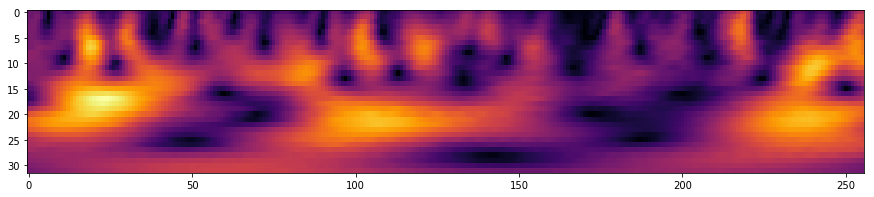

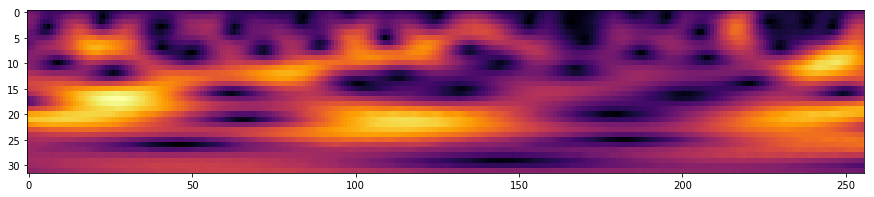

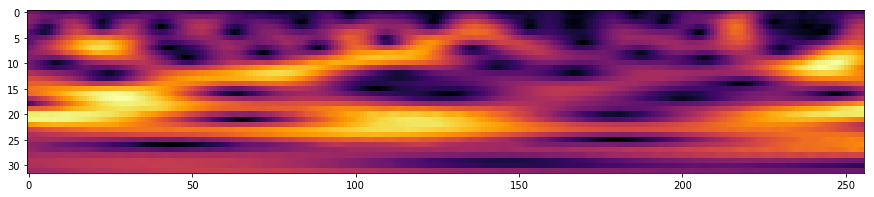

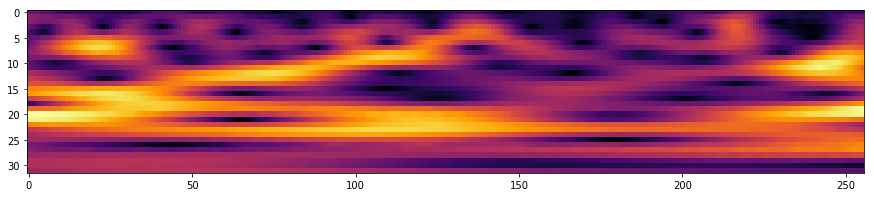

In [7]:
# Compute CWT the usual way
start_time = time.time()
minibatch_cwt, freqs = get_cwt_minibatch(minibatch)
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("CWT", minibatch_cwt.shape)
print(freqs)

# Show one example
example = 0

context_size = int(params['context']*params['fs'])
context_start = int(params['factor_border']*params['context']*params['fs']/2)
context_end = context_start + context_size 
for chan in range(minibatch_cwt.shape[3]):
    plt.figure(figsize=(15, 3))
    plt.imshow(minibatch_cwt[example,:,:,chan], interpolation='none', cmap=cm.inferno, aspect='auto')
    plt.show()

In [51]:
def compute_single_cwt(signal):
    fs = 200
    fc = 1
    fb_array = np.array([0.5, 1, 1.5, 2])
    n_scales = 32
    upper_freq = 40
    lower_freq = 2
    # Generate initial and last scale
    s_0 = fs / upper_freq
    s_n = fs / lower_freq
    # Generate the array of scales
    base = np.power(s_n / s_0, 1 / (n_scales - 1))
    scales = s_0 * np.power(base, range(n_scales))
    # Set wavelet
    w = pywt.ContinuousWavelet('cmor')
    w.center_frequency = fc
    # Compute scalograms
    context_size = int(params['context'] * fs)
    context_start = int(params['factor_border']*params['context']*params['fs'] / 2)
    context_end = context_start + context_size
    features_cwt = np.zeros((n_scales, context_size, fb_array.shape[0]), dtype=np.float32)
    for j in range(fb_array.shape[0]):
        w.bandwidth_frequency = fb_array[j]
        coef, freqs = pywt.cwt(signal, scales, w, 1 / fs)
        abs_coef = np.abs(coef[:, context_start:context_end])
        # Spectrum flattening
        abs_coef = abs_coef * freqs[:, np.newaxis]
        features_cwt[:, :, j] = abs_coef
    return features_cwt

Time usage: 0.1249847412109375 [s]
CWT (32, 256, 4)


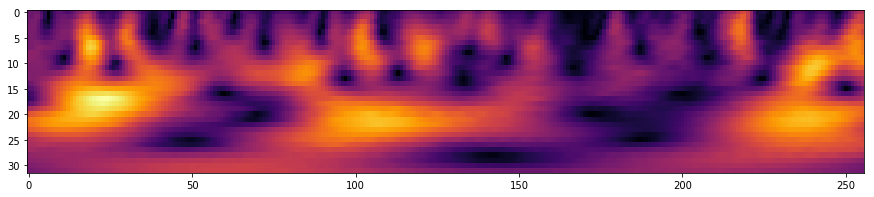

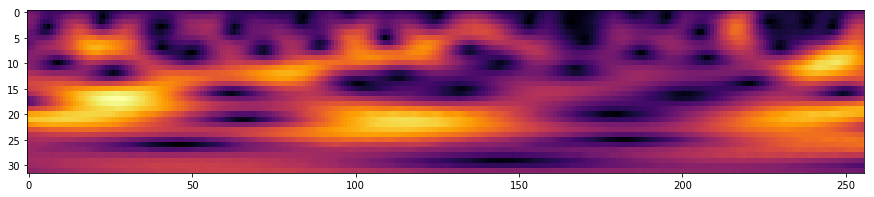

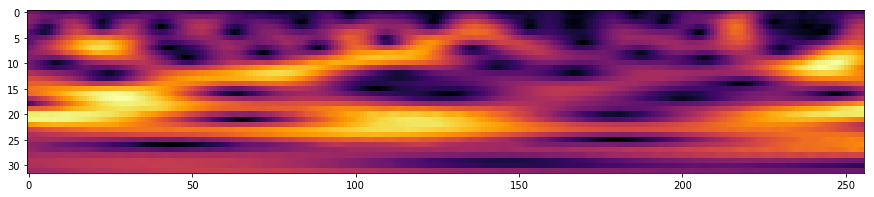

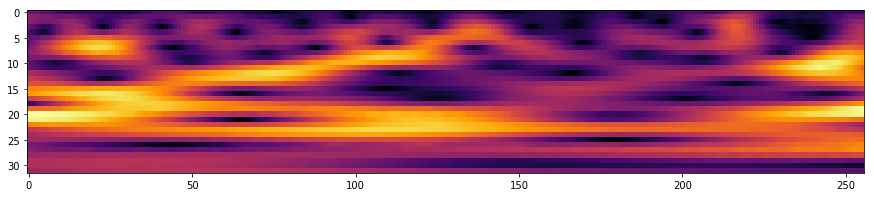

In [9]:
# Test time of single cwt
start_time = time.time()
single_cwt = compute_single_cwt(minibatch[0,:])
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("CWT", single_cwt.shape)

context_size = int(params['context']*params['fs'])
context_start = int(params['factor_border']*params['context']*params['fs']/2)
context_end = context_start + context_size 
for chan in range(single_cwt.shape[-1]):
    plt.figure(figsize=(15, 3))
    plt.imshow(single_cwt[:,:,chan], interpolation='none', cmap=cm.inferno, aspect='auto')
    plt.show()

In [10]:
# Compute CWT using tf
# Just a baseline in time

# 32 scales (filters) at 4 fb values -> 128 filters for each single example
signal_ph = tf.placeholder(shape=[None, minibatch.shape[1]], dtype=tf.float32)
signal_ph_reshape = tf.expand_dims(signal_ph, 1)
signal_ph_reshape = tf.expand_dims(signal_ph_reshape, 3)
# cwt_op = tf.map_fn(compute_single_cwt, signal_ph, parallel_iterations=256, back_prop=False)
cwt_op_prev = tf.layers.conv2d(inputs=signal_ph_reshape, filters=128, kernel_size=(1,100), padding="same")
cwt_op_reshape = tf.reshape(cwt_op_prev, [-1, 32, 256*3, 4])
cwt_op = cwt_op_reshape[:, :, 256:512, :]

start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    minibatch_cwt = sess.run(cwt_op, feed_dict={signal_ph: minibatch})
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("CWT TF Dummy baseline", minibatch_cwt.shape)

Time usage: 0.07811951637268066 [s]
CWT TF Dummy baseline (64, 32, 256, 4)


Original Signal


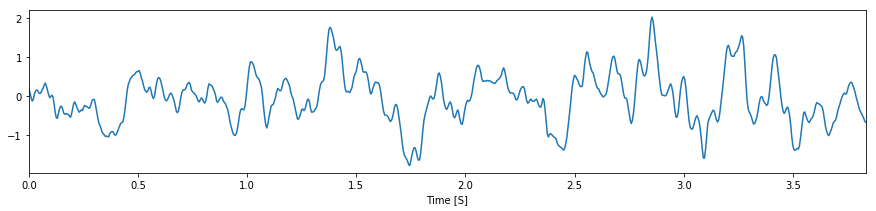

Original CWT implementation
Time usage: 0.10937213897705078 [s]
Original CWT (32, 256, 4)


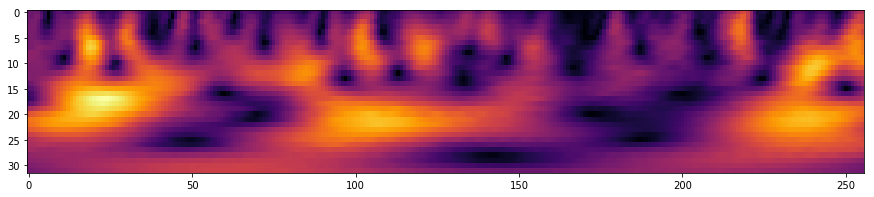

TF implementation
Time usage: 1.7186264991760254 [s]
CWT (1, 32, 256, 4)


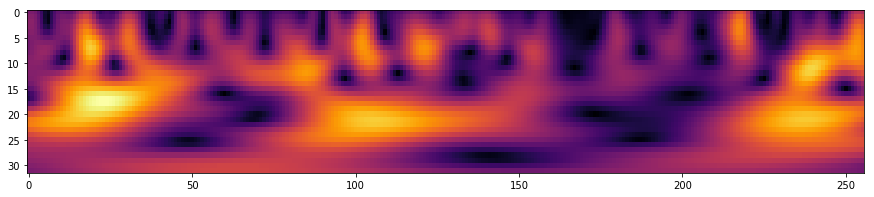

In [70]:
# Original CWT for comparison
# Test time of single cwt
print("Original Signal")
single_signal = minibatch[0]
plt.figure(figsize=(15, 3))
time_array = np.arange(len(single_signal))/fs
plt.plot( time_array, single_signal)
plt.xlabel("Time [S]")
plt.xlim((0, time_array[-1]))
plt.show()


print("Original CWT implementation")
start_time = time.time()
single_cwt = compute_single_cwt(minibatch[0,:])
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("Original CWT", single_cwt.shape)

context_size = int(params['context']*params['fs'])
context_start = int(params['factor_border']*params['context']*params['fs']/2)
context_end = context_start + context_size 
chan=0 #fb_array[0] = 0.5
plt.figure(figsize=(15, 3))
plt.imshow(single_cwt[:,:,chan], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()

print("TF implementation")
# Compute a single CWT with TF (example zero)
# Using only fb_array[0] = 0.5

fs = 200
fc = 1
fb_array = np.array([0.5, 1, 1.5, 2])
n_scales = 32
upper_freq = 40
lower_freq = 2
# Generate initial and last scale
s_0 = fs / upper_freq
s_n = fs / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, range(n_scales))

# Generate kernels
kernels_morlet = []
for j in range(len(fb_array)):
    fb = fb_array[j]
    fb_kernels_morlet = []
    for i in range(n_scales):
        this_scale = scales[i]
        one_side = int(this_scale*np.sqrt(10*fb))
        this_kernel_size = 2*one_side+1
        #print("Kernel size for freq",fs/this_scale,this_kernel_size)
        this_k = np.arange(this_kernel_size, dtype=np.float32) - one_side
        this_kernel = np.exp( -((this_k/this_scale)**2)/fb) / np.sqrt(np.pi * fb  * this_scale)
        this_kernel_real = this_kernel * np.cos(2*np.pi*fc*this_k/this_scale)
        this_kernel_imag = this_kernel * np.sin(2*np.pi*fc*this_k/this_scale)
        fb_kernels_morlet.append((this_kernel_real,this_kernel_imag))
    kernels_morlet.append(fb_kernels_morlet)
#last_kernel_real = kernels_morlet[-1][0]
#last_kernel_imag = kernels_morlet[-1][1]
#time_array = np.arange(len(last_kernel_real))/fs
#plt.plot(time_array,last_kernel_real)
#plt.plot(time_array,last_kernel_imag)
#plt.title("Morlet for 2Hz")

signal_ph = tf.placeholder(shape=[None, minibatch.shape[1]], dtype=tf.float32)
signal_ph_reshape = tf.expand_dims(signal_ph, 1)
signal_ph_reshape = tf.expand_dims(signal_ph_reshape, -1) # Make it 4D tensor

# Apply kernels
def apply_complex_kernel(kernel_tuple, input_signal, context_start, context_end):
    kernel_real = kernel_tuple[0]
    kernel_imag = kernel_tuple[1]
    useful_shape = (1,) + kernel_real.shape + (1,1)
    kernel_real = np.reshape(kernel_real, useful_shape)
    kernel_imag = np.reshape(kernel_imag, useful_shape)
    out_real = tf.nn.conv2d(input=input_signal, filter=kernel_real, strides=[1,1,1,1], padding="SAME")
    out_imag = tf.nn.conv2d(input=input_signal, filter=kernel_imag, strides=[1,1,1,1], padding="SAME")
    out_real_context = out_real[:, :, context_start:context_end, :]
    out_imag_context = out_imag[:, :, context_start:context_end, :]
    out_abs = tf.sqrt(tf.square(out_real_context) + tf.square(out_imag_context))
    return out_abs
 
cwt_list = []
for j in range(len(fb_array)):
    fb_cwt_list = []
    for i in range(n_scales):
        this_kernel_tuple = kernels_morlet[j][i]
        power = apply_complex_kernel(this_kernel_tuple, signal_ph_reshape, context_start, context_end)
        # Spectrum flattening
        power = power * (fs/scales[i])
        fb_cwt_list.append(power)
    single_scalogram = tf.concat(fb_cwt_list, 1)
    cwt_list.append(single_scalogram)
cwt_op = tf.concat(cwt_list, -1)

start_time = time.time()
with tf.Session() as sess:
    single_signal = np.reshape(single_signal, (1,)+single_signal.shape) # Make it like a batch of size 1
    minibatch_cwt = sess.run(cwt_op, feed_dict={signal_ph: single_signal})
    #minibatch_cwt = sess.run(cwt_op, feed_dict={signal_ph: minibatch})
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("CWT", minibatch_cwt.shape)

plt.figure(figsize=(15, 3))
plt.imshow(minibatch_cwt[0,:,:,0], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()

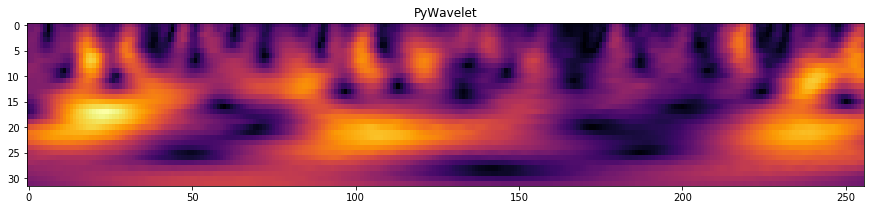

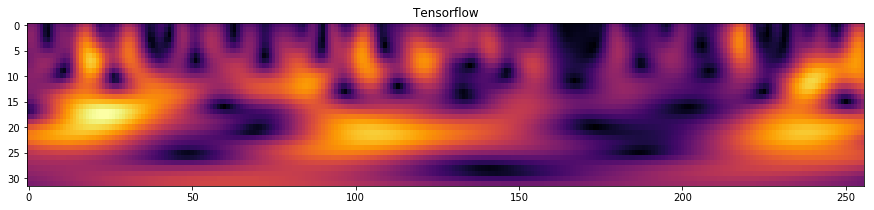

In [60]:
chan=0 #fb_array[0] = 0.5

plt.figure(figsize=(15, 3))
plt.imshow(single_cwt[:,:,chan], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.title("PyWavelet")
plt.show()


plt.figure(figsize=(15, 3))
plt.imshow(minibatch_cwt[0,:,:,chan], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.title("Tensorflow")
plt.show()


Original Signal


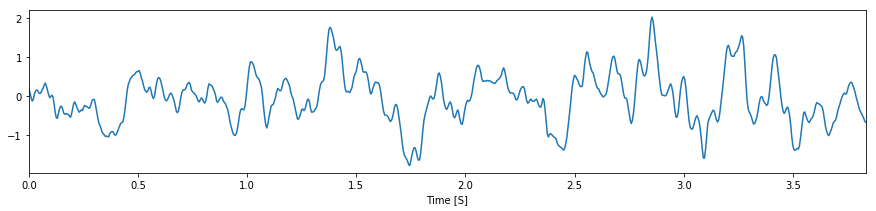

Original CWT implementation
Time usage: 0.09374618530273438 [s]
Original CWT (32, 256, 4)


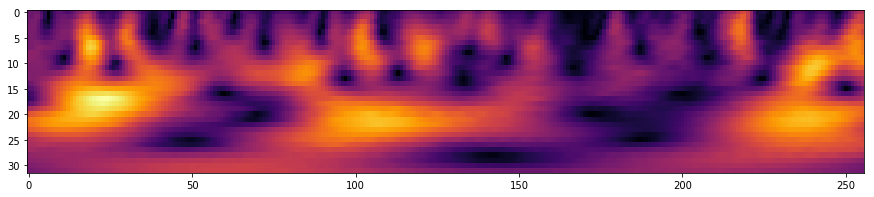

TF implementation
(2, 447, 32)
(2, 633, 32)
(2, 775, 32)
(2, 895, 32)
Time usage: 1.0780515670776367 [s]
CWT (1, 32, 256, 1)


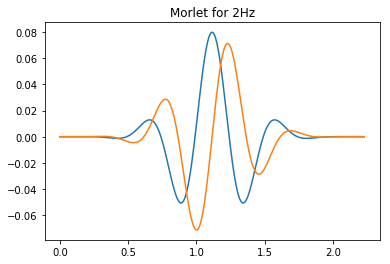

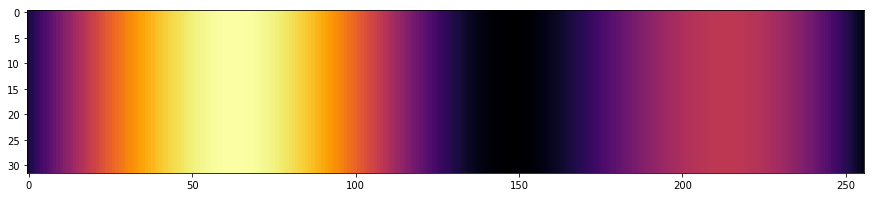

In [74]:
# Test with zero-padding
# Original CWT for comparison
# Test time of single cwt
print("Original Signal")
single_signal = minibatch[0]
plt.figure(figsize=(15, 3))
time_array = np.arange(len(single_signal))/fs
plt.plot( time_array, single_signal)
plt.xlabel("Time [S]")
plt.xlim((0, time_array[-1]))
plt.show()


print("Original CWT implementation")
start_time = time.time()
single_cwt = compute_single_cwt(minibatch[0,:])
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("Original CWT", single_cwt.shape)

context_size = int(params['context']*params['fs'])
context_start = int(params['factor_border']*params['context']*params['fs']/2)
context_end = context_start + context_size 
chan=0 #fb_array[0] = 0.5
plt.figure(figsize=(15, 3))
plt.imshow(single_cwt[:,:,chan], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()

print("TF implementation")
# Compute a single CWT with TF (example zero)
# Using only fb_array[0] = 0.5

fs = 200
fc = 1
fb_array = np.array([0.5, 1, 1.5, 2])
n_scales = 32
upper_freq = 40
lower_freq = 2
# Generate initial and last scale
s_0 = fs / upper_freq
s_n = fs / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, range(n_scales))

# Generate kernels
kernel_list = []
for j in range(len(fb_array)):
    fb = fb_array[j]
    max_scale = np.max(scales)
    one_side = int(max_scale*np.sqrt(10*fb))
    max_kernel_size = 2*one_side+1
    k_array = np.arange(max_kernel_size, dtype=np.float32) - one_side
    fb_kernel = np.zeros((2, max_kernel_size, n_scales))
    for i in range(n_scales):
        this_kernel = np.exp( -((k_array/this_scale)**2)/fb) / np.sqrt(np.pi * fb  * this_scale)
        this_kernel_real = this_kernel * np.cos(2*np.pi*fc*k_array/this_scale)
        this_kernel_imag = this_kernel * np.sin(2*np.pi*fc*k_array/this_scale)
        fb_kernel[0, :, i] = this_kernel_real
        fb_kernel[1, :, i] = this_kernel_imag
    print(fb_kernel.shape)
    kernel_list.append(fb_kernel)
last_kernel_real = kernel_list[0][0,:,-1]
last_kernel_imag = kernel_list[0][1,:,-1]
time_array = np.arange(len(last_kernel_real))/fs
plt.plot(time_array,last_kernel_real)
plt.plot(time_array,last_kernel_imag)
plt.title("Morlet for 2Hz")

signal_ph = tf.placeholder(shape=[None, minibatch.shape[1]], dtype=tf.float32)
signal_ph_reshape = tf.expand_dims(signal_ph, 1)
signal_ph_reshape = tf.expand_dims(signal_ph_reshape, -1) # Make it 4D tensor
 
def get_scalogram(fb_kernel, input_signal, context_start, context_end):
    kernel_real = fb_kernel[0,:,:]
    kernel_imag = fb_kernel[1,:,:]
    n_scales = kernel_real.shape[-1]
    kernel_size = kernel_real.shape[0]
    #kernel_concat = np.concatenate((kernel_real, kernel_imag), axis=-1) # (447, 64)
    useful_shape = (1, kernel_size, 1, n_scales)
    kernel_real = np.reshape(kernel_real, useful_shape)
    kernel_imag = np.reshape(kernel_imag, useful_shape)
    #kernel_concat = np.expand_dims(kernel_concat, 0)
    #kernel_concat = np.expand_dims(kernel_concat, 2)
    out_real = tf.nn.conv2d(input=input_signal,
                              filter=kernel_real,
                              strides=[1,1,1,1], padding="SAME")
    out_imag = tf.nn.conv2d(input=input_signal,
                              filter=kernel_imag,
                              strides=[1,1,1,1], padding="SAME")
    out_real_context = out_real[:, :, context_start:context_end, :]
    out_imag_context = out_imag[:, :, context_start:context_end, :]
    out_abs = tf.sqrt(tf.square(out_real_context) + tf.square(out_imag_context))
    out_abs = tf.transpose(out_abs, perm=[0, 3, 2, 1])
    #freqs = fs/scales
    return out_abs
fb_kernel = kernel_list[0]
cwt_op = get_scalogram(fb_kernel, signal_ph_reshape, context_start, context_end)
    
#cwt_list = []
#for j in range(len(fb_array)):
#    fb_cwt_list = []
#    for i in range(n_scales):
#        this_kernel_tuple = kernels_morlet[j][i]
#        power = apply_complex_kernel(this_kernel_tuple, signal_ph_reshape, context_start, context_end)
#        # Spectrum flattening
#        power = power * (fs/scales[i])
#        fb_cwt_list.append(power)
#    single_scalogram = tf.concat(fb_cwt_list, 1)
#    cwt_list.append(single_scalogram)
#cwt_op = tf.concat(cwt_list, -1)

start_time = time.time()
with tf.Session() as sess:
    single_signal = np.reshape(single_signal, (1,)+single_signal.shape) # Make it like a batch of size 1
    minibatch_cwt = sess.run(cwt_op, feed_dict={signal_ph: single_signal})
    #minibatch_cwt = sess.run(cwt_op, feed_dict={signal_ph: minibatch})
time_usage = time.time() - start_time
print("Time usage: " + str(time_usage) + " [s]")
print("CWT", minibatch_cwt.shape)

plt.figure(figsize=(15, 3))
plt.imshow(minibatch_cwt[0,:,:,0], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()